In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda')

class ProbeClassifier(nn.Module):
    def __init__(self):
        super(ProbeClassifier, self).__init__()
        self.dense = nn.Linear(768, 768)
        self.norm = nn.BatchNorm1d(768)
        self.dropout = nn.Dropout(0.2)
        self.out_proj = nn.Linear(768, 4)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.dense(x)
        x = self.norm(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda')

class ProbeClassifier(nn.Module):
    def __init__(self):
        super(ProbeClassifier, self).__init__()
        # 定义一个RNN层 (可以根据需要使用 LSTM 或 GRU)
        self.lstm = nn.LSTM(768, 768, batch_first=True)
        # 定义一个全连接层，用于四分类任务
        self.fc = nn.Linear(768, 4)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda')

class ProbeClassifier(nn.Module):
    def __init__(self):
        super(ProbeClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3)
        self.drop = nn.Dropout(0.2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 766 // 2, 128)  # 768 - 3 + 1 (conv) / 2 (pool)
        self.fc2 = nn.Linear(128, 4)  # 4个类别

    def forward(self, x):
        # print("1", x.shape)
        x = self.conv1(x)  # (64, 32, 766)
        # x = self.drop(x)
        # print("2", x.shape)
        x = self.pool(x)   # (64, 32, 383)
        # print("3", x.shape)
        x = x.view(x.size(0), -1)  # 展平
        x = self.fc1(x)
        # x = self.drop(x)
        x = self.fc2(x)
        return x

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda')

class ProbeClassifier(nn.Module):
    def __init__(self, input_size=768, num_heads=12, num_layers=1, hidden_size=768, num_classes=4):
        super(ProbeClassifier, self).__init__()
        
        # 线性变换层，用于调整输入到 Transformer 的维度
        self.embedding = nn.Linear(input_size, hidden_size)
        
        # Transformer 编码器层
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 分类头，输出层
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # 激活函数
        self.relu = nn.ReLU()

    def forward(self, x):
        # 输入嵌入变换
        x = self.embedding(x)
        x = self.relu(x)
        
        # Transformer 编码器的输入
        # (batch_size, seq_len, hidden_size) -> (seq_len, batch_size, hidden_size) for Transformer
        x = x.permute(1, 0, 2)
        
        # 通过 Transformer Encoder 处理
        x = self.transformer(x)
        
        # 我们通常只取最后一个时间步的输出用于分类
        x = x.mean(dim=0)  # 平均池化也可以取最后一个时间步
        
        # 输出层
        x = self.fc(x)
        return x

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss, AllKNN, InstanceHardnessThreshold
from imblearn.combine import SMOTETomek
import pickle
import torch
import numpy as np

train_data = torch.load("./train_attentions_3th.pt")

label = [x[1] for x in train_data]
pt_data = [x[0].detach().cpu() for x in train_data]

# print(len(pt_data), len(label))
# print(pt_data[0])


X_train, X_test, y_train, y_test = train_test_split(pt_data, label, test_size=0.2, random_state=42)

print("test:", np.bincount(y_test))
print("Before SMOTE:", np.bincount(y_train))
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# smote = SMOTETomek(sampling_strategy='auto', random_state=42)
smote = TomekLinks(sampling_strategy=[0,1])
X_train, y_train = smote.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train))
class_counts = torch.tensor(np.bincount(y_train), dtype=torch.float32)

# X_train, X_test, y_train, y_test = train_test_split(pt_data, label, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long).to(device)

print(y_train_tensor)
print(torch.sum(y_train_tensor).item()/len(y_train_tensor))
print((len(y_train_tensor) - torch.sum(y_train_tensor).item())/len(y_train_tensor))

# 创建训练和测试的Dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 创建DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

test: [ 672 1396    0   32]
Before SMOTE: [2638 5659    0  103]
After SMOTE: [2521 5543    0  103]
tensor([1, 0, 0,  ..., 1, 0, 1], device='cuda:0')
0.7165421819517571
0.28345781804824294


In [3]:
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, NearMiss, AllKNN
from imblearn.combine import SMOTETomek
import pickle
import torch
import numpy as np

train_data = torch.load("./train_attentions.pt")
label = [x[1] for x in train_data]
pt_data = [x[0] for x in train_data]

for i in range(len(label)):
    if label[i] != 1:
        label[i] = 0
    else:
        label[i] = 1

X_train, X_test, y_train, y_test = train_test_split(pt_data, label, test_size=0.2, random_state=42)

print("Before SMOTE:", np.bincount(y_train))
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# smote = SMOTETomek(sampling_strategy='auto', random_state=42)
smote = TomekLinks(sampling_strategy='auto')
X_train, y_train = smote.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train))

# X_train, X_test, y_train, y_test = train_test_split(pt_data, label, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.long).to(device)

print(y_train_tensor)
print(torch.sum(y_train_tensor).item()/len(y_train_tensor))
print((len(y_train_tensor) - torch.sum(y_train_tensor).item())/len(y_train_tensor))

# 创建训练和测试的Dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 创建DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: './train_attentions.pt'

In [3]:
from transformers import RobertaConfig, RobertaForSequenceClassification
model = ProbeClassifier().to(device)

# config = RobertaConfig.from_pretrained('microsoft/codebert-base')
# config.num_labels = 1
# modelx = RobertaForSequenceClassification.from_pretrained('microsoft/codebert-base', config=config)

# source_parameters_dense = modelx.classifier.dense.state_dict()
# source_parameters_out_proj = modelx.classifier.out_proj.state_dict()

# model.dense.load_state_dict(source_parameters_dense)
# model.out_proj.load_state_dict(source_parameters_out_proj)

# for param_source, param_target in zip(modelx.classifier.dense.parameters(), model.dense.parameters()):
#     assert torch.equal(param_source, param_target)

In [ ]:

criterion = nn.CrossEntropyLoss()  # 多分类问题使用交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model.eval()  # 设置模型为评估模式
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        outputs = model(data).squeeze()
        predicted = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the model on test set: {accuracy * 100:.2f}%')

# 训练过程
model.train()
num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # 前向传播
        scores = model(data).squeeze()
        loss = criterion(scores, targets.float())

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 打印训练进度
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            total_loss = 0.0
            total_samples = 0
            with torch.no_grad():
                for data, targets in test_loader:
                    # 获取模型的预测结果
                    outputs = model(data).squeeze()

                    # 计算损失
                    loss = criterion(outputs, targets.float())

                    # 累积损失
                    total_loss += loss.item() * data.size(0)
                    total_samples += data.size(0)

            # 计算平均损失
            average_loss = total_loss / total_samples
            print(f"Average test loss: {average_loss:.4f}")

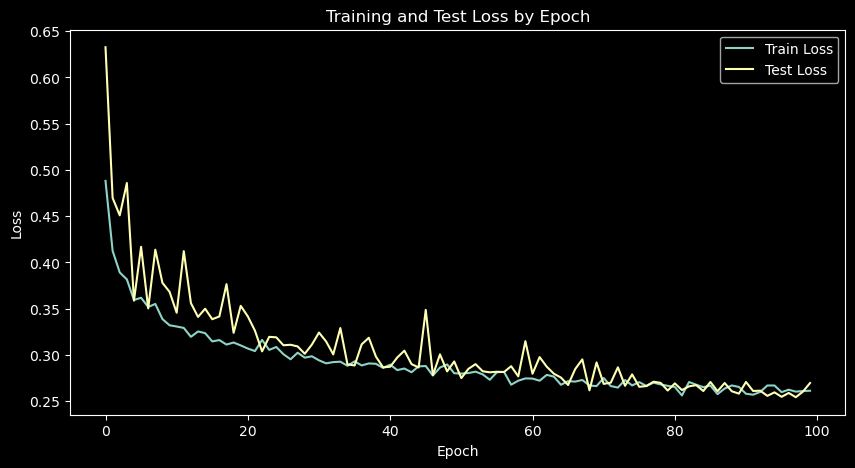

Epoch 1: Train Loss: 0.4882, Test Loss: 0.6327
Epoch 2: Train Loss: 0.4125, Test Loss: 0.4697
Epoch 3: Train Loss: 0.3891, Test Loss: 0.4509
Epoch 4: Train Loss: 0.3816, Test Loss: 0.4858
Epoch 5: Train Loss: 0.3594, Test Loss: 0.3586
Epoch 6: Train Loss: 0.3617, Test Loss: 0.4168
Epoch 7: Train Loss: 0.3518, Test Loss: 0.3503
Epoch 8: Train Loss: 0.3551, Test Loss: 0.4137
Epoch 9: Train Loss: 0.3387, Test Loss: 0.3779
Epoch 10: Train Loss: 0.3320, Test Loss: 0.3682
Epoch 11: Train Loss: 0.3306, Test Loss: 0.3455
Epoch 12: Train Loss: 0.3291, Test Loss: 0.4121
Epoch 13: Train Loss: 0.3195, Test Loss: 0.3560
Epoch 14: Train Loss: 0.3253, Test Loss: 0.3410
Epoch 15: Train Loss: 0.3235, Test Loss: 0.3499
Epoch 16: Train Loss: 0.3146, Test Loss: 0.3385
Epoch 17: Train Loss: 0.3160, Test Loss: 0.3415
Epoch 18: Train Loss: 0.3111, Test Loss: 0.3765
Epoch 19: Train Loss: 0.3133, Test Loss: 0.3238
Epoch 20: Train Loss: 0.3102, Test Loss: 0.3530
Epoch 21: Train Loss: 0.3068, Test Loss: 0.3416
E

In [4]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from IPython.display import clear_output


class_weights = class_counts.sum() / class_counts
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.8, 1.0, 0.9, 1.0]).to(device)) #Good for 9
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.2, 1.0, 0.8, 1.0]).to(device)) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

model.train()
num_epochs = 100

# 初始化损失跟踪列表
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    total_train_loss = 0
    total_train_samples = 0
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # 前向传播
        # data = data.unsqueeze(1)
        # print(data.shape)
        scores = model(data).squeeze()
        # print(scores[1], targets.shape)
        loss = criterion(scores, targets)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累积训练损失
        total_train_loss += loss.item() * data.size(0)
        total_train_samples += data.size(0)

    # 计算每个epoch的平均训练损失
    average_train_loss = total_train_loss / total_train_samples
    train_losses.append(average_train_loss)
    # scheduler.step()
    
    # 测试损失计算
    total_loss = 0.0
    total_samples = 0
    model.eval()  # 切换到评估模式
    with torch.no_grad():
        for data, targets in test_loader:
            # data = data.unsqueeze(1)
            outputs = model(data).squeeze()
            loss = criterion(outputs, targets)
            total_loss += loss.item() * data.size(0)
            total_samples += data.size(0)

    average_loss = total_loss / total_samples
    test_losses.append(average_loss)

    # 切换回训练模式
    model.train()

    # 绘制训练和测试损失
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss by Epoch')
    plt.legend()
    plt.show()

for i in range(num_epochs):
    print(f"Epoch {i+1}: Train Loss: {train_losses[i]:.4f}, Test Loss: {test_losses[i]:.4f}")


In [5]:
from sklearn.metrics import confusion_matrix
model.eval()  # 设置模型为评估模式

preds = []
ylabels = []
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        # data = data.unsqueeze(1)
        outputs = model(data).squeeze()
        outputs = torch.softmax(outputs, dim=-1)
        predicted = torch.argmax(outputs, dim=-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted.cpu().numpy())
        ylabels.extend(labels.cpu().numpy())

cm = confusion_matrix(ylabels, preds)
print(preds)
print(cm)
accuracy_per_class = cm.diagonal() / cm.sum(axis=0)

# 打印结果
for i, acc in enumerate(accuracy_per_class):
    print(f"Class {i}: {acc:.2f}")

accuracy = correct / total
print(f'Accuracy of the model on test set: {accuracy * 100:.2f}%')

[1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 3, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 

In [ ]:
torch.save(model.state_dict(), 'ProbeClassifier.pth')

In [ ]:
model.load_state_dict(torch.load('ProbeClassifier.pth'))

<All keys matched successfully>